In [51]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as image
from glob import glob

%matplotlib inline

In [52]:
os.listdir('.')

['stage1_train_labels.csv',
 'stage1_solution.csv',
 '.ipynb_checkpoints',
 'stage1_sample_submission.csv',
 'stage1_test',
 'Basic_EDA.ipynb',
 'stage2_test_final',
 'stage2_sample_submission_final.csv',
 'stage1_train']

In [53]:
HOME_DIR = ''
STAGE_1_LABELS = 'stage1_train_labels.csv'
STAGE_1_SOLUTION = 'stage1_solution.csv'
STAGE_1_TEST = 'stage1_test'
STAGE_1_TRAIN = 'stage1_train'
STAGE_2_TEST = 'stage2_test_final'

We are given some desription about the data we will deal with but let's have a quick glance at the images we have got.

stage1_test/472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71/images/472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71.png
stage1_test/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4/images/53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4.png
stage1_test/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f/images/fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f.png
stage1_test/519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0/images/519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0.png
stage1_train/2255d5aba044256bb92f6b7cbed0fca46d972c7b6b1a59dcbe7f682c5777d074/masks/3e584d4719ebabe2261ad100d4468d581d7eaeca28f038ba46caad6a96246278.png
stage1_train/e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f/masks/13303724a7d365ed46180a31495fc6c0056c6f68d5bbcf22e57cd79d9025bec0.png
stage1_train/53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc/mask

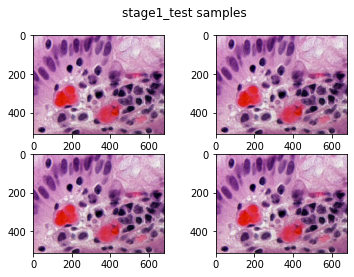

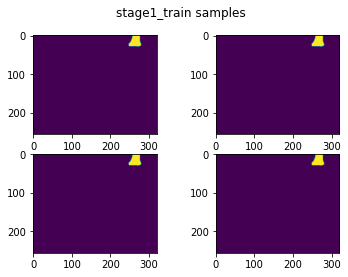

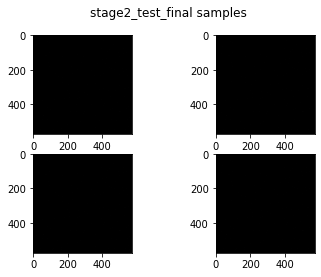

In [63]:
def sample_plots(directory):
    
    sample = []
    for i in range(4):
        subplots = []
        for d in os.listdir(directory):        
            file = os.listdir(os.path.join(directory, d))[0]
            #print(file)
            res_dir = os.path.join(directory, d, file)
            im = image.imread(os.path.join(res_dir, os.listdir(res_dir)[0]))
            print(os.path.join(res_dir, os.listdir(res_dir)[0]))
            subplots.append(im)
            sample.append(im)
            if len(subplots)==4:
                break
        fig, axs = plt.subplots(2, 2)
        fig.suptitle(f'{directory} samples')
        axs[0, 0].imshow(subplots[0])
        axs[1, 0].imshow(subplots[0])
        axs[0, 1].imshow(subplots[0])
        axs[1, 1].imshow(subplots[0])
        break
    return sample

test_1 = sample_plots(STAGE_1_TEST)
train_1 = sample_plots(STAGE_1_TRAIN)
test_2 = sample_plots(STAGE_2_TEST)
    

That is interesting. There seems to be no difference in images. Let's check if we are mistaken.

In [55]:
assert test_1[0] != test_1[1]
assert train_1[0] != train_1[1]
assert test_2[0] != test_2[1]

print('First image of the sample has a shape', test_1[0].shape, 'while the second', test_1[1].shape)
stage_1_train_ids = next(os.walk(STAGE_1_TRAIN))[1]

First image of the sample has a shape (512, 680, 3) while the second (256, 256, 4)


<ipython-input-55-89028384225e>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert test_1[0] != test_1[1]
<ipython-input-55-89028384225e>:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert train_1[0] != train_1[1]
<ipython-input-55-89028384225e>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert test_2[0] != test_2[1]


Well images are different indeed. Let's try to check if masks are reflecting the images at all.

In [68]:
all_images = glob(os.path.join(HOME_DIR, 'stage1_*', '*', '*', '*'))

img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)

img_df = img_df.sample(100)
img_df['path'].tolist()[0]

'stage1_train/0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe/masks/d2d1dd78077aff74c885af0f3643f2eca4a47c40816af2f2c041418ec7c5f06d.png'

In [70]:
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']

for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
    
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3

def read_and_stack(in_img_list):
    return np.sum(np.stack([plt.imread(c_img) for c_img in in_img_list], 0), 0)/255.0

train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

ValueError: need at least one array to stack